# [역설계 및 복원 평가] 분류 및 연속모델 복합 구조 cVAE 촉매 최적화
### NVAE(2020) 기반 KL Balancing [0.01, 0.005, 0.002] 및 Recon 1:1:1 가중치 반영

In [1]:
import os, sys, torch, json
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 경로 설정
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from multilayer_model.m3_multi_bce import M3_Multi_BCE
from multilayer_model.m3_multi_mse import M3_Multi_MSE
from multilayer_loss.l_multi3_final_logic import l_multi3_final_loss
from vae_earlystopping import EarlyStopping

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 800
print(f"Active Device: {device}")

Active Device: cuda


In [2]:
x1_raw = np.load('../data/metal.npy')
x2_raw = np.load('../data/support_norm.npy')
x3_raw = np.load('../data/pre_fin.npy')
c_raw = np.load('../data/re_fin.npy')

idx = np.arange(len(x1_raw))
tr_idx, te_idx = train_test_split(idx, test_size=0.1, random_state=42)
tr_idx, va_idx = train_test_split(tr_idx, test_size=0.1, random_state=42)

sc1, sc2, sc3, scc = MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
def prep(d, i, s, fit=False): return s.fit_transform(d[i]) if fit else s.transform(d[i])

x1_tr, x1_va, x1_te = prep(x1_raw, tr_idx, sc1, True), prep(x1_raw, va_idx, sc1), prep(x1_raw, te_idx, sc1)
x2_tr, x2_va, x2_te = prep(x2_raw, tr_idx, sc2, True), prep(x2_raw, va_idx, sc2), prep(x2_raw, te_idx, sc2)
x3_tr, x3_va, x3_te = prep(x3_raw, tr_idx, sc3, True), prep(x3_raw, va_idx, sc3), prep(x3_raw, te_idx, sc3)
c_tr, c_va, c_te = prep(c_raw, tr_idx, scc, True), prep(c_raw, va_idx, scc), prep(c_raw, te_idx, scc)

def to_t(a): return torch.tensor(a, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(to_t(x1_tr), to_t(x2_tr), to_t(x3_tr), to_t(c_tr)), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(to_t(x1_va), to_t(x2_va), to_t(x3_va), to_t(c_va)), batch_size=64)
test_loader = DataLoader(TensorDataset(to_t(x1_te), to_t(x2_te), to_t(x3_te), to_t(c_te)), batch_size=64)

x_dims = [x1_tr.shape[1], x2_tr.shape[1], x3_tr.shape[1]]
c_dim = c_tr.shape[1]

In [3]:
def train_expert(model, mode='mse'):
    opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    es = EarlyStopping(patience=40, min_delta=1e-9)
    
    for epoch in range(1, EPOCHS + 1):
        model.train()
        for b1, b2, b3, bc in train_loader:
            b1, b2, b3, bc = b1.to(device), b2.to(device), b3.to(device), bc.to(device)
            opt.zero_grad()
            p, m, v = model(b1, b2, b3, bc)
            # 요청하신 1:1:1 Recon & [0.01, 0.005, 0.002] KL 적용
            loss = l_multi3_final_loss(p, [b1, b2, b3], m, v, mode=mode, gamma_list=[0.01, 0.005, 0.002])
            loss.backward(); opt.step()
        
        model.eval()
        v_loss = 0
        with torch.no_grad():
            for v1, v2, v3, vc in val_loader:
                v1, v2, v3, vc = v1.to(device), v2.to(device), v3.to(device), vc.to(device)
                vp, vm, vv = model(v1, v2, v3, vc)
                v_loss += l_multi3_final_loss(vp, [v1, v2, v3], vm, vv, mode=mode).item()
        
        if epoch % 100 == 0: print(f"[{mode.upper()}] Epoch {epoch} | Val Loss: {v_loss/len(val_loader):.6f}")
        if es(v_loss/len(val_loader), model): break
    es.load_best_model(model)
    return model

print("Training Stage 1: BCE Specialist...")
m_bce = train_expert(M3_Multi_BCE(x_dims, c_dim).to(device), 'bce')
print("\nTraining Stage 2: MSE Specialist...")
m_mse = train_expert(M3_Multi_MSE(x_dims, c_dim).to(device), 'mse')

Training Stage 1: BCE Specialist...
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping count

In [4]:
print("\n--- 1. Reconstruction Evaluation (Forward Design) ---")
m_bce.eval(); m_mse.eval()
all_re_gen, all_re_true = [], []

with torch.no_grad():
    for b1, b2, b3, bc in test_loader:
        b1, b2, b3, bc = b1.to(device), b2.to(device), b3.to(device), bc.to(device)
        
        # Reconstruction: 정답 데이터를 인코더에 넣어 복원력을 테스트함
        b_re_logits, _, _ = m_bce(b1, b2, b3, bc)
        m_re_vals, _, _ = m_mse(b1, b2, b3, bc)
        
        # Phase 1 Metal Gating
        prob_re = torch.sigmoid(b_re_logits[0])
        val_re = m_re_vals[0]
        final_re = prob_re * val_re
        
        all_re_gen.append(sc1.inverse_transform(final_re.cpu().numpy()))
        all_re_true.append(sc1.inverse_transform(b1.cpu().numpy()))

y_p_re, y_t_re = np.concatenate(all_re_gen).flatten(), np.concatenate(all_re_true).flatten()
print(f"Reconstruction R2 (Metal): {r2_score(y_t_re, y_p_re):.4f}")


--- 1. Reconstruction Evaluation (Forward Design) ---
Reconstruction R2 (Metal): 0.9389



--- 2. Pure Generation Evaluation (Inverse Design) ---
Generation (Inverse Design) R2 (Metal): 0.2210


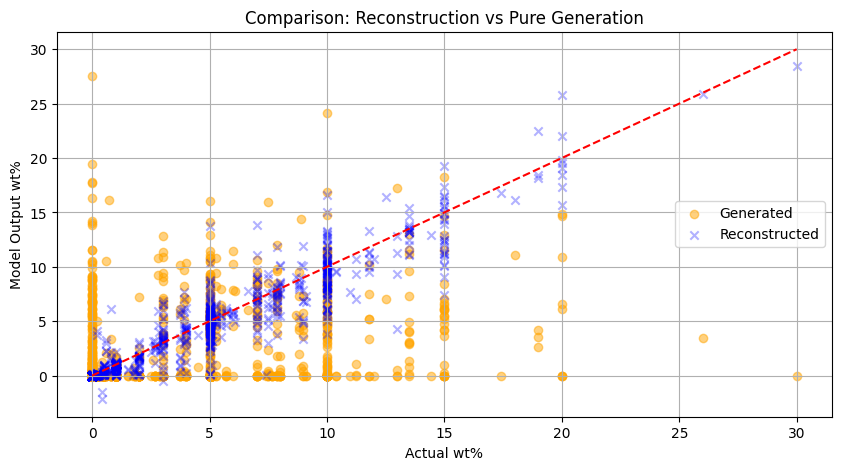

In [5]:
print("\n--- 2. Pure Generation Evaluation (Inverse Design) ---")
all_gen, all_true = [], []

with torch.no_grad():
    for b1, b2, b3, bc in test_loader:
        bc = bc.to(device)
        # Generation: 정답 없이 오직 조건 bc만으로 잠재 공간 샘플링하여 생성
        b_gen = m_bce.generate(bc, device)
        m_gen = m_mse.generate(bc, device)
        
        prob_g = torch.sigmoid(b_gen[0])
        val_g = m_gen[0]
        final_g = prob_g * val_g
        
        # Noise Thresholding
        final_g[final_g < 1e-3] = 0
        
        all_gen.append(sc1.inverse_transform(final_g.cpu().numpy()))
        all_true.append(sc1.inverse_transform(b1.numpy()))

y_p_gen, y_t_gen = np.concatenate(all_gen).flatten(), np.concatenate(all_true).flatten()
gen_r2 = r2_score(y_t_gen, y_p_gen)
print(f"Generation (Inverse Design) R2 (Metal): {gen_r2:.4f}")

# 시각화
plt.figure(figsize=(10, 5))
plt.scatter(y_t_gen, y_p_gen, alpha=0.5, color='orange', label='Generated')
plt.scatter(y_t_re, y_p_re, alpha=0.3, color='blue', label='Reconstructed', marker='x')
plt.plot([0, y_t_gen.max()], [0, y_t_gen.max()], 'r--')
plt.title("Comparison: Reconstruction vs Pure Generation")
plt.xlabel("Actual wt%"); plt.ylabel("Model Output wt%")
plt.legend(); plt.grid(True); plt.show()